# Load environment

In [1]:
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import pandas as pd
import numpy as np
import random
import itertools

from tqdm import tqdm

import decoupler as dc
import sys

sys.setrecursionlimit(20000)

sys.path.append("./../../../../utilities_folder")
from utilities import load_object, intTable, plotGenesInTerm, getAnnGenes, run_ora_catchErrors

Set R environment with rpy2:

In [2]:
import rpy2.rinterface_lib.callbacks
import anndata2ri
import logging

from rpy2.robjects import pandas2ri
import rpy2.robjects as ro

sc.settings.verbosity = 0
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

Set up of graphical parameters for Python plots:

In [3]:
%matplotlib inline
sc.set_figure_params(dpi = 300, fontsize = 20)

plt.rcParams['svg.fonttype'] = 'none'

cmap_up = sns.light_palette("red", as_cmap=True)
cmap_down = sns.light_palette("blue", as_cmap=True)
cmap_all = sns.light_palette("seagreen", as_cmap=True)

Set up of graphical parameters for R plots:

In [4]:
default_units = 'in' 
default_res = 300
default_width = 10
default_height = 9

import rpy2
old_setup_graphics = rpy2.ipython.rmagic.RMagics.setup_graphics

def new_setup_graphics(self, args):
    if getattr(args, 'units') is not None:
        if args.units != default_units:
            return old_setup_graphics(self, args)
    args.units = default_units
    if getattr(args, 'res') is None:
        args.res = default_res
    if getattr(args, 'width') is None:
        args.width = default_width
    if getattr(args, 'height') is None:
        args.height = default_height        
    return old_setup_graphics(self, args)


rpy2.ipython.rmagic.RMagics.setup_graphics = new_setup_graphics

Here the cell were we inject the parameters using Quarto renderer:

In [5]:
#| tags: [parameters]
# Injected Parameters
N = 3

In [6]:
#| tags: [parameters]
# Injected Parameters
N = 13


Import R libraries:

In [7]:
%%R
source('./../../../../utilities_folder/GO_helper.r')
loc <- './../../../../R_loc' # pointing to the renv environment

.libPaths(loc)

library('topGO')
library('org.Hs.eg.db')
library(dplyr)
library(ggplot2)

Set output folders:

In [8]:
output_folder = './'
folder = './tables/cluster_' + str(N) + '/'

# Load data
Here we load the dataframe:

In [9]:
markers = pd.read_excel(folder + 'genes_in_cluster_' + str(N) + '.xlsx', index_col = 0)
markers

,logFC.celltypes_leveledhEGCLC,logFC.celltypes_leveledhPGCLC,logFC.celltypes_levelediMeLC,logCPM,LR,PValue,FDR,clusters
ACTA1,11.493834,0,13.291811,2.882094,511.356736,1.649850e-110,2.513090e-109,13
SPIB,12.364728,0,11.586142,2.885391,486.441048,4.140128e-105,5.818964e-104,13
SERTAD4,10.616763,0,12.800036,2.279025,413.057395,3.286390e-89,3.487758e-88,13
CACNG4,11.786840,0,11.698635,2.475937,406.995026,6.760063e-88,7.025198e-87,13
EMILIN1,11.896756,0,10.995019,2.425626,404.247221,2.661738e-87,2.735346e-86,13
POPDC3,11.216938,0,11.819366,2.133988,353.461856,2.655021e-76,2.210001e-75,13
MLKL,10.852160,0,12.158127,2.061818,352.706863,3.868575e-76,3.213461e-75,13
AC007906.2,10.481626,0,12.280169,1.950036,350.659466,1.073694e-75,8.863514e-75,13
FBXO48,11.367965,0,11.230980,2.070526,342.220777,7.212057e-74,5.744282e-73,13
CCDC3,10.619262,0,12.101212,1.921517,339.272319,3.136467e-73,2.469474e-72,13


In [10]:
allGenes_series = pd.read_csv('./tables/all_bkg_genes.csv')
allGenes = allGenes_series['0'].tolist()

Here we load the dictionary that associates to each GO term its genes:

In [11]:
GO2gene = load_object('./../../../../data/GO2gene_complete.pickle')

# Markers of cluster

We filter genes for the cluster under investigation based on the p-value adjusted that we then convert in -log(p-value adjusted):

In [12]:

markers = markers[markers.FDR < 0.01]
markers['-log10(FDR)'] = -np.log10(markers.FDR)
markers = markers.replace(np.inf, markers[markers['-log10(FDR)'] != np.inf]['-log10(FDR)'].max())
markers

,logFC.celltypes_leveledhEGCLC,logFC.celltypes_leveledhPGCLC,logFC.celltypes_levelediMeLC,logCPM,LR,PValue,FDR,clusters,-log10(FDR)
ACTA1,11.493834,0,13.291811,2.882094,511.356736,1.649850e-110,2.513090e-109,13,108.599792
SPIB,12.364728,0,11.586142,2.885391,486.441048,4.140128e-105,5.818964e-104,13,103.235154
SERTAD4,10.616763,0,12.800036,2.279025,413.057395,3.286390e-89,3.487758e-88,13,87.457454
CACNG4,11.786840,0,11.698635,2.475937,406.995026,6.760063e-88,7.025198e-87,13,86.153341
EMILIN1,11.896756,0,10.995019,2.425626,404.247221,2.661738e-87,2.735346e-86,13,85.562988
POPDC3,11.216938,0,11.819366,2.133988,353.461856,2.655021e-76,2.210001e-75,13,74.655607
MLKL,10.852160,0,12.158127,2.061818,352.706863,3.868575e-76,3.213461e-75,13,74.493027
AC007906.2,10.481626,0,12.280169,1.950036,350.659466,1.073694e-75,8.863514e-75,13,74.052394
FBXO48,11.367965,0,11.230980,2.070526,342.220777,7.212057e-74,5.744282e-73,13,72.240764
CCDC3,10.619262,0,12.101212,1.921517,339.272319,3.136467e-73,2.469474e-72,13,71.607396


### All regulated

In [13]:
all_sign = markers.index.tolist()
allSelected = allGenes_series['0'].isin(all_sign).astype('int').tolist()

# topGO

## All significant

In [14]:
%%R -i allSelected -i allGenes

allGenes_v <- c(allSelected)
#print(allGenes_v)
names(allGenes_v) <- allGenes
allGenes_v <- unlist(allGenes_v)

geneNames <- c(allGenes)

ann_org_BP <- topGO::annFUN.org(whichOnto='BP', feasibleGenes=names(allGenes_v), 
                           mapping='org.Hs.eg', ID='symbol')

ann_org_MF <- topGO::annFUN.org(whichOnto='MF', feasibleGenes=names(allGenes_v), 
                           mapping='org.Hs.eg', ID='symbol')

ann_org_CC <- topGO::annFUN.org(whichOnto='CC', feasibleGenes=names(allGenes_v), 
                           mapping='org.Hs.eg', ID='symbol')

selection <- function(allScores){return (as.logical(allScores))}

::: {.panel-tabset}

### Biological Process

In [15]:
%%R
#print(lapply(ann_org_BP, count_genes))

GOdata <- new("topGOdata",
  ontology="BP",
  allGenes=allGenes_v,
  annot=annFUN.GO2genes,
  GO2genes=ann_org_BP,
  geneSel = selection,
  nodeSize=10)

In [16]:
%%R -o results

results <- runTest(GOdata, algorithm="weight01",statistic="fisher")

In [17]:
scores = ro.r.score(results)
score_names = ro.r(
'''
names(results@score)
'''
)
go_data = ro.r.GOdata

genesData = ro.r(
'''
geneData(results)
'''
)
genesData

array([10903,    25,    10,  1082], dtype=int32)

In [18]:
#num_summarize = min(100, len(score_names))
results_table = ro.r.GenTable(go_data, weight=results,
        orderBy="weight", topNodes=len(scores))

In [19]:
results_table_py = ro.conversion.rpy2py(results_table)

In [20]:
scores_py = ro.conversion.rpy2py(scores)
score_names = [i for i in score_names]

In [21]:
scores_df = pd.DataFrame({'Scores': scores_py, 'GO.ID': score_names})
results_table_py = results_table_py.merge(scores_df, left_on = 'GO.ID', right_on = 'GO.ID')
results_table_py

,GO.ID,Term,Annotated,Significant,Expected,weight,Scores
0,GO:0050918,positive chemotaxis,33,2,0.08,0.0026,0.002552
1,GO:0014068,positive regulation of phosphatidylinosi...,45,2,0.10,0.0047,0.004704
2,GO:0030199,collagen fibril organization,45,2,0.10,0.0047,0.004704
3,GO:0090130,tissue migration,235,4,0.54,0.0062,0.006173
4,GO:0051897,positive regulation of protein kinase B ...,71,2,0.16,0.0114,0.011387
...,...,...,...,...,...,...,...
5697,GO:2001251,negative regulation of chromosome organi...,88,0,0.20,1.0000,1.000000
5698,GO:2001252,positive regulation of chromosome organi...,93,0,0.21,1.0000,1.000000
5699,GO:2001256,regulation of store-operated calcium ent...,11,0,0.03,1.0000,1.000000
5700,GO:2001258,negative regulation of cation channel ac...,23,0,0.05,1.0000,1.000000


In [22]:
results_table_py = results_table_py[results_table_py['Scores'] < 0.05]
results_table_py = results_table_py[results_table_py['Annotated'] < 200]
results_table_py = results_table_py[results_table_py['Annotated'] > 15]

In [23]:
results_table_py['-log10(pvalue)'] = - np.log10(results_table_py.Scores)
results_table_py['Significant/Annotated'] = results_table_py['Significant'] / results_table_py['Annotated']

In [24]:
intTable(results_table_py, folder = folder, fileName = 'GO_BP_all.xlsx', save = True)

Column
    [0] FileDownload(_transfers=1, auto=False, button_type='success', data='data:application/octet-st..., embed=True, file='./tables/cluster_13/GO_BP..., filename='GO_BP_all.xlsx', label='Download GO_BP_all.xlsx')
    [1] Tabulator(page_size=10, pagination='remote', value=         GO.ID  ...)

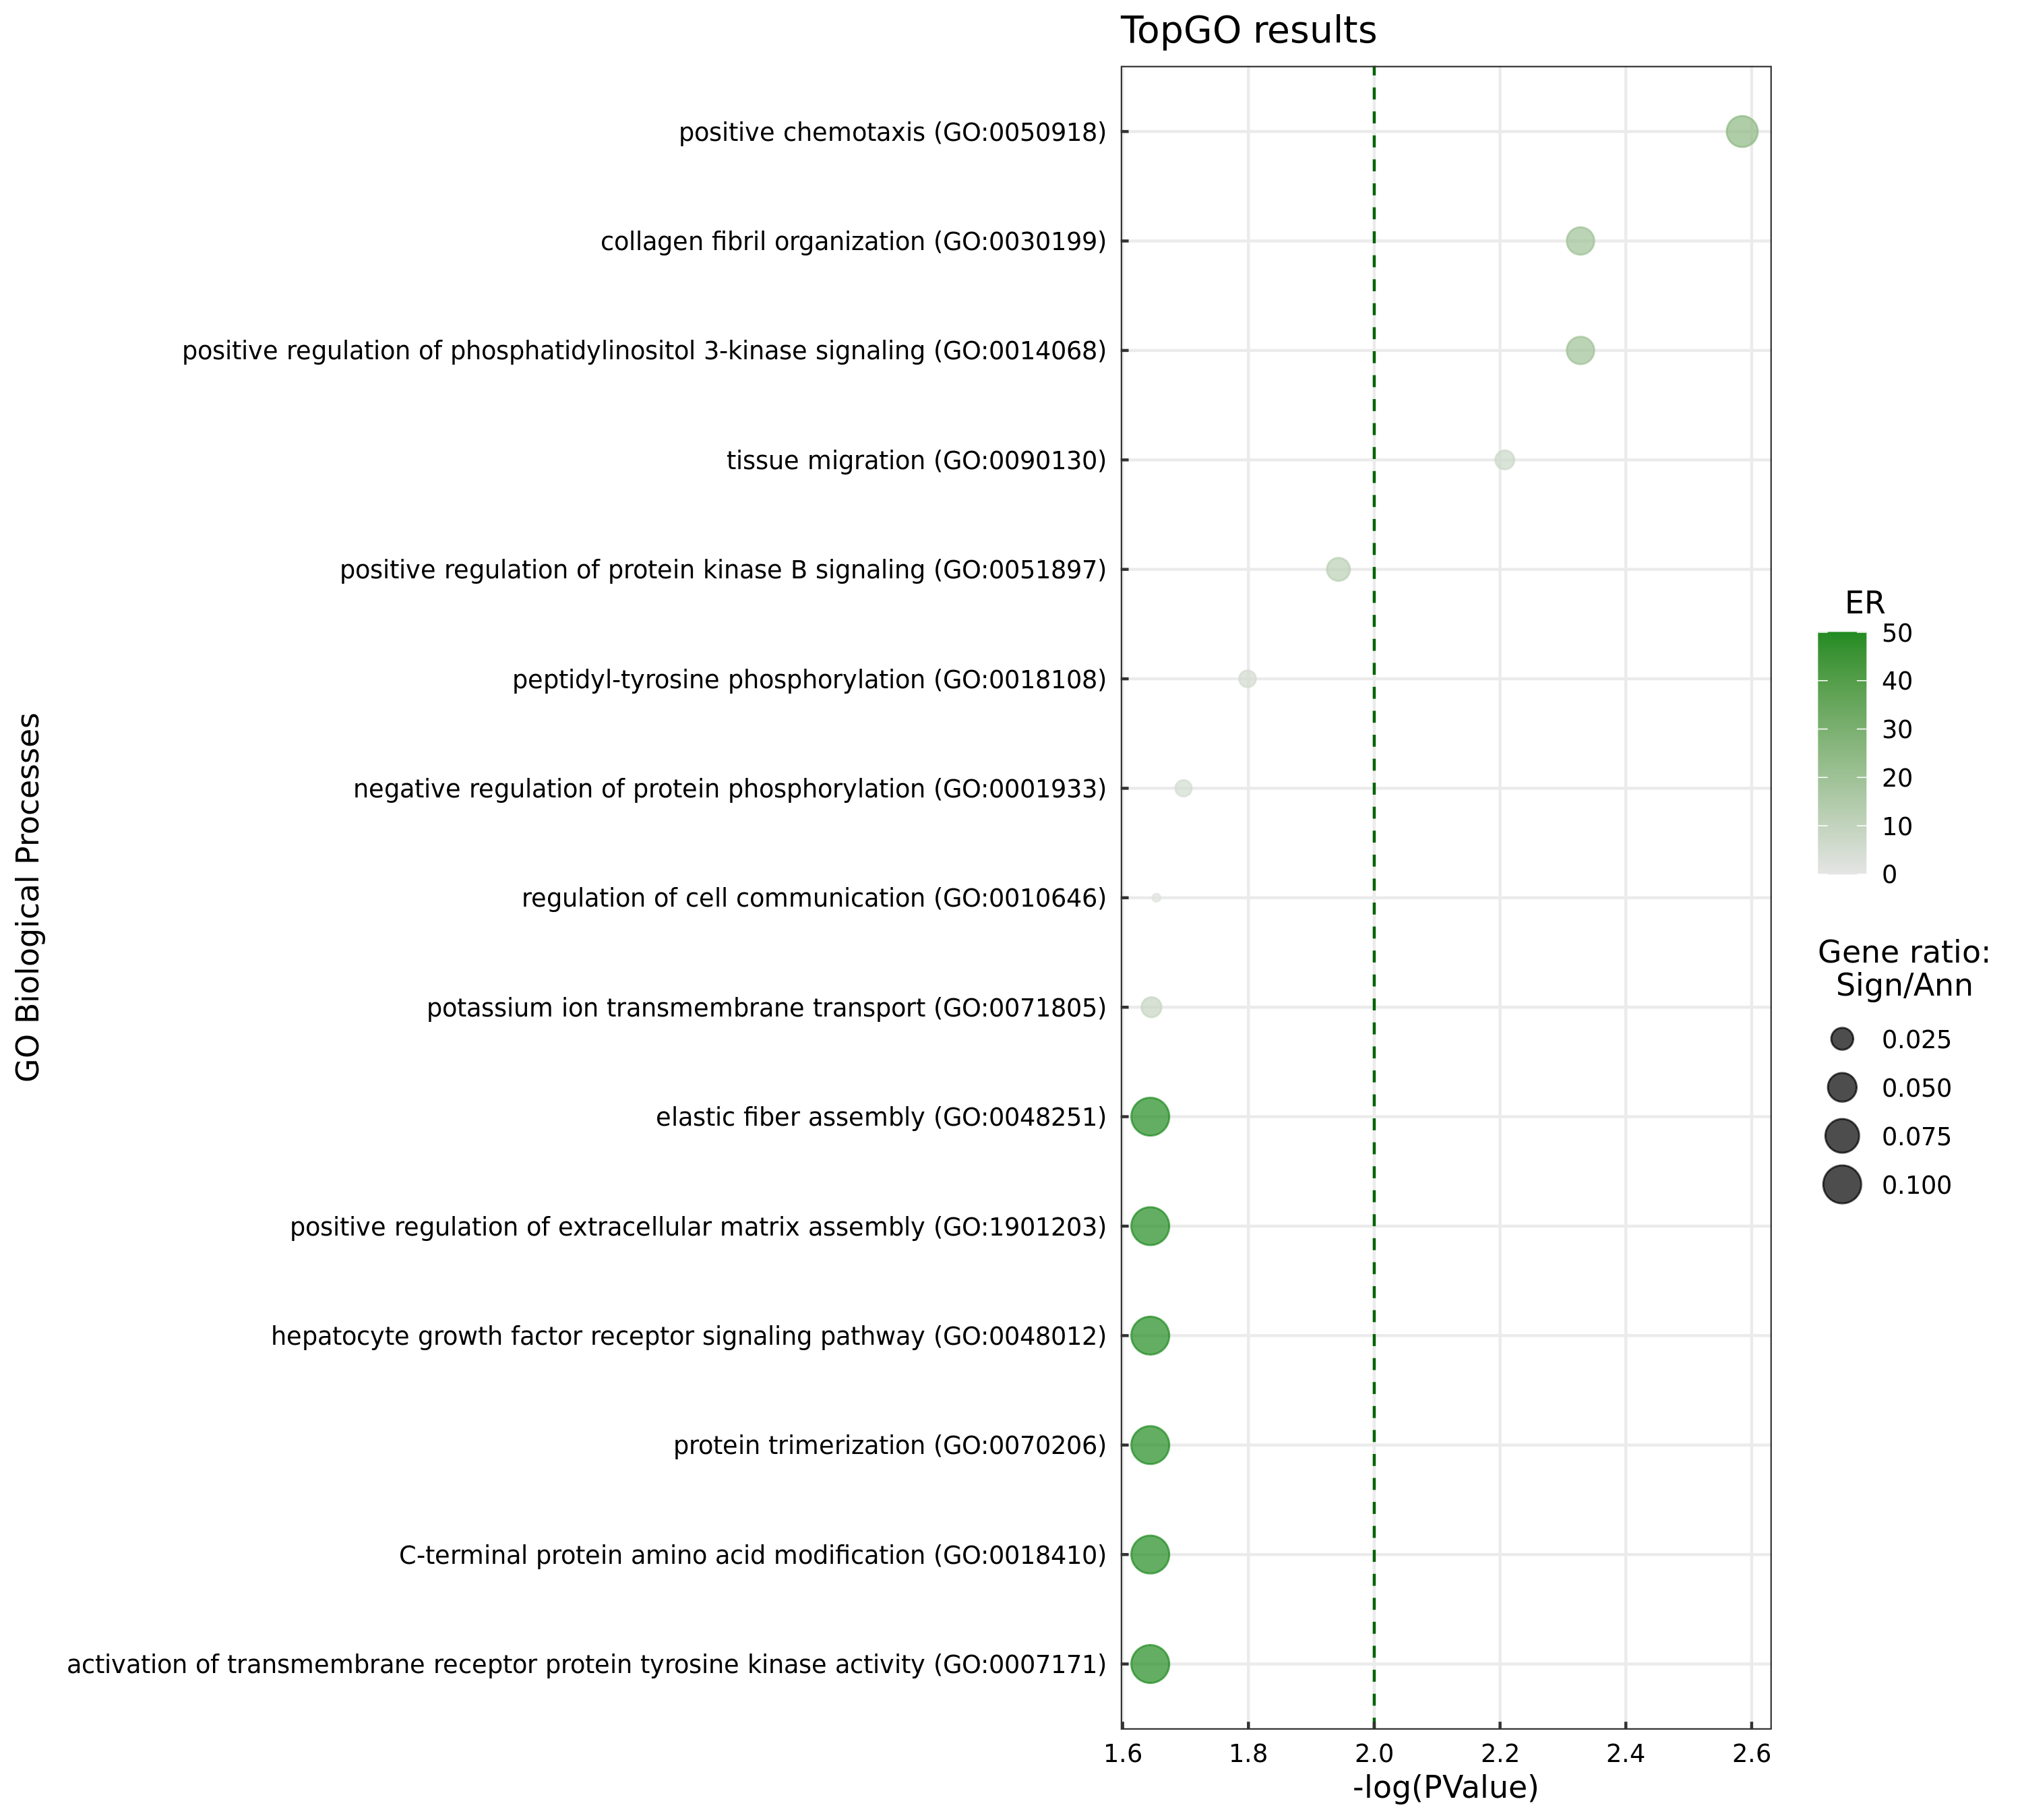

In [25]:
%%R -i folder
Res <- GenTable(GOdata, weight=results,
        orderBy="weight", topNodes=length(score(results)))
#print(Res[0:10,])
colnames(Res) <- c("GO.ID", "Term", "Annotated", "Significant", "Expected", "Statistics")
Res$ER <- Res$Significant / Res$Expected

image = bubbleplot(Res, Ont = 'BP', fillCol = 'forestgreen')
ggsave(file=paste0(folder, "TopGO_results_BP.pdf"), plot=image, width=12, height=4)

bubbleplot(Res, Ont = 'BP', fillCol = 'forestgreen')

In [26]:
#| echo: False

default_width = 20
default_height = 7
rpy2.ipython.rmagic.RMagics.setup_graphics = new_setup_graphics

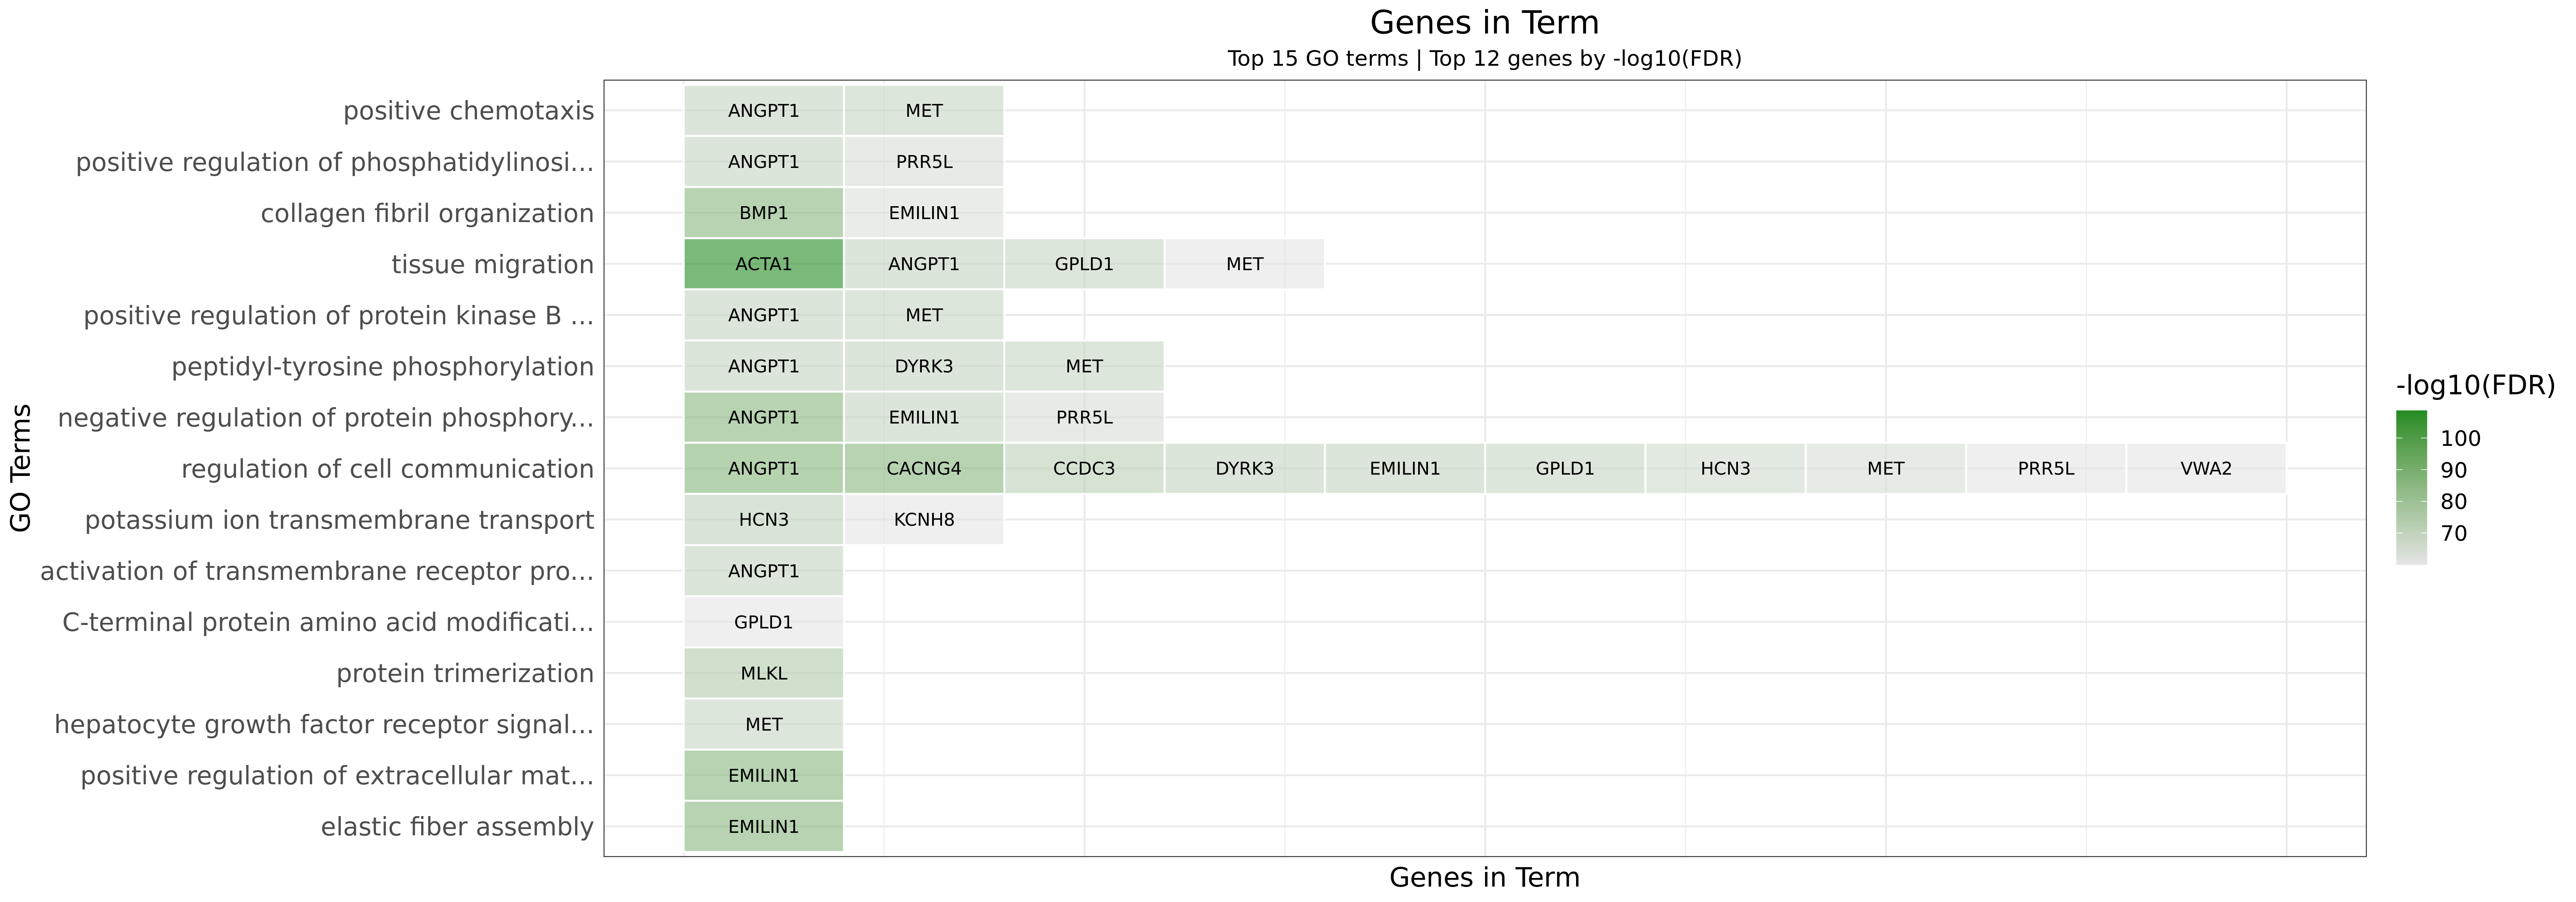

In [27]:
%%R -i markers
image = plotGenesInTerm_v1(Res, GOdata, SE = markers, nterms=15, ngenes=12,
                             fillCol='forestgreen', log = TRUE)

ggsave(file=paste0(folder, "Genes_in_Term_results_BP.pdf"), plot=image, width=12, height=4)

plotGenesInTerm_v1(Res, GOdata, SE = markers, nterms=15, ngenes=12,
                             fillCol='forestgreen', log = TRUE)

In [28]:
%%R -i markers -i folder
saveGenesInTerm(Res, GOdata, nterms = 20, path = paste0(folder,'GO_BP_genesInTerm_all.xlsx'), SE = markers)

In [29]:
#| echo: False

default_width = 15
default_height = 9
rpy2.ipython.rmagic.RMagics.setup_graphics = new_setup_graphics

### Molecular Function

In [30]:
%%R

GOdata <- new("topGOdata",
  ontology="MF",
  allGenes=allGenes_v,
  annot=annFUN.GO2genes,
  GO2genes=ann_org_MF,
  geneSel = selection,
  nodeSize=10)

In [31]:
%%R -o results

results <- runTest(GOdata, algorithm="weight01",statistic="fisher")

In [32]:
scores = ro.r.score(results)
score_names = ro.r(
'''
names(results@score)
'''
)
go_data = ro.r.GOdata

genesData = ro.r(
'''
geneData(results)
'''
)
genesData

array([11203,    28,    10,   150], dtype=int32)

In [33]:
#num_summarize = min(100, len(score_names))
results_table = ro.r.GenTable(go_data, weight=results,
        orderBy="weight", topNodes=len(scores))

In [34]:
results_table_py = ro.conversion.rpy2py(results_table)

In [35]:
scores_py = ro.conversion.rpy2py(scores)
score_names = [i for i in score_names]

In [36]:
scores_df = pd.DataFrame({'Scores': scores_py, 'GO.ID': score_names})
results_table_py = results_table_py.merge(scores_df, left_on = 'GO.ID', right_on = 'GO.ID')
results_table_py = results_table_py[results_table_py['Scores'] < 0.05]
results_table_py = results_table_py[results_table_py['Annotated'] < 200]
results_table_py = results_table_py[results_table_py['Annotated'] > 15]

intTable(results_table_py, folder = folder, fileName = 'GO_MF_all.xlsx', save = True)

Column
    [0] FileDownload(_transfers=1, auto=False, button_type='success', data='data:application/octet-st..., embed=True, file='./tables/cluster_13/GO_MF..., filename='GO_MF_all.xlsx', label='Download GO_MF_all.xlsx')
    [1] Tabulator(page_size=10, pagination='remote', value=        GO.ID  ...)

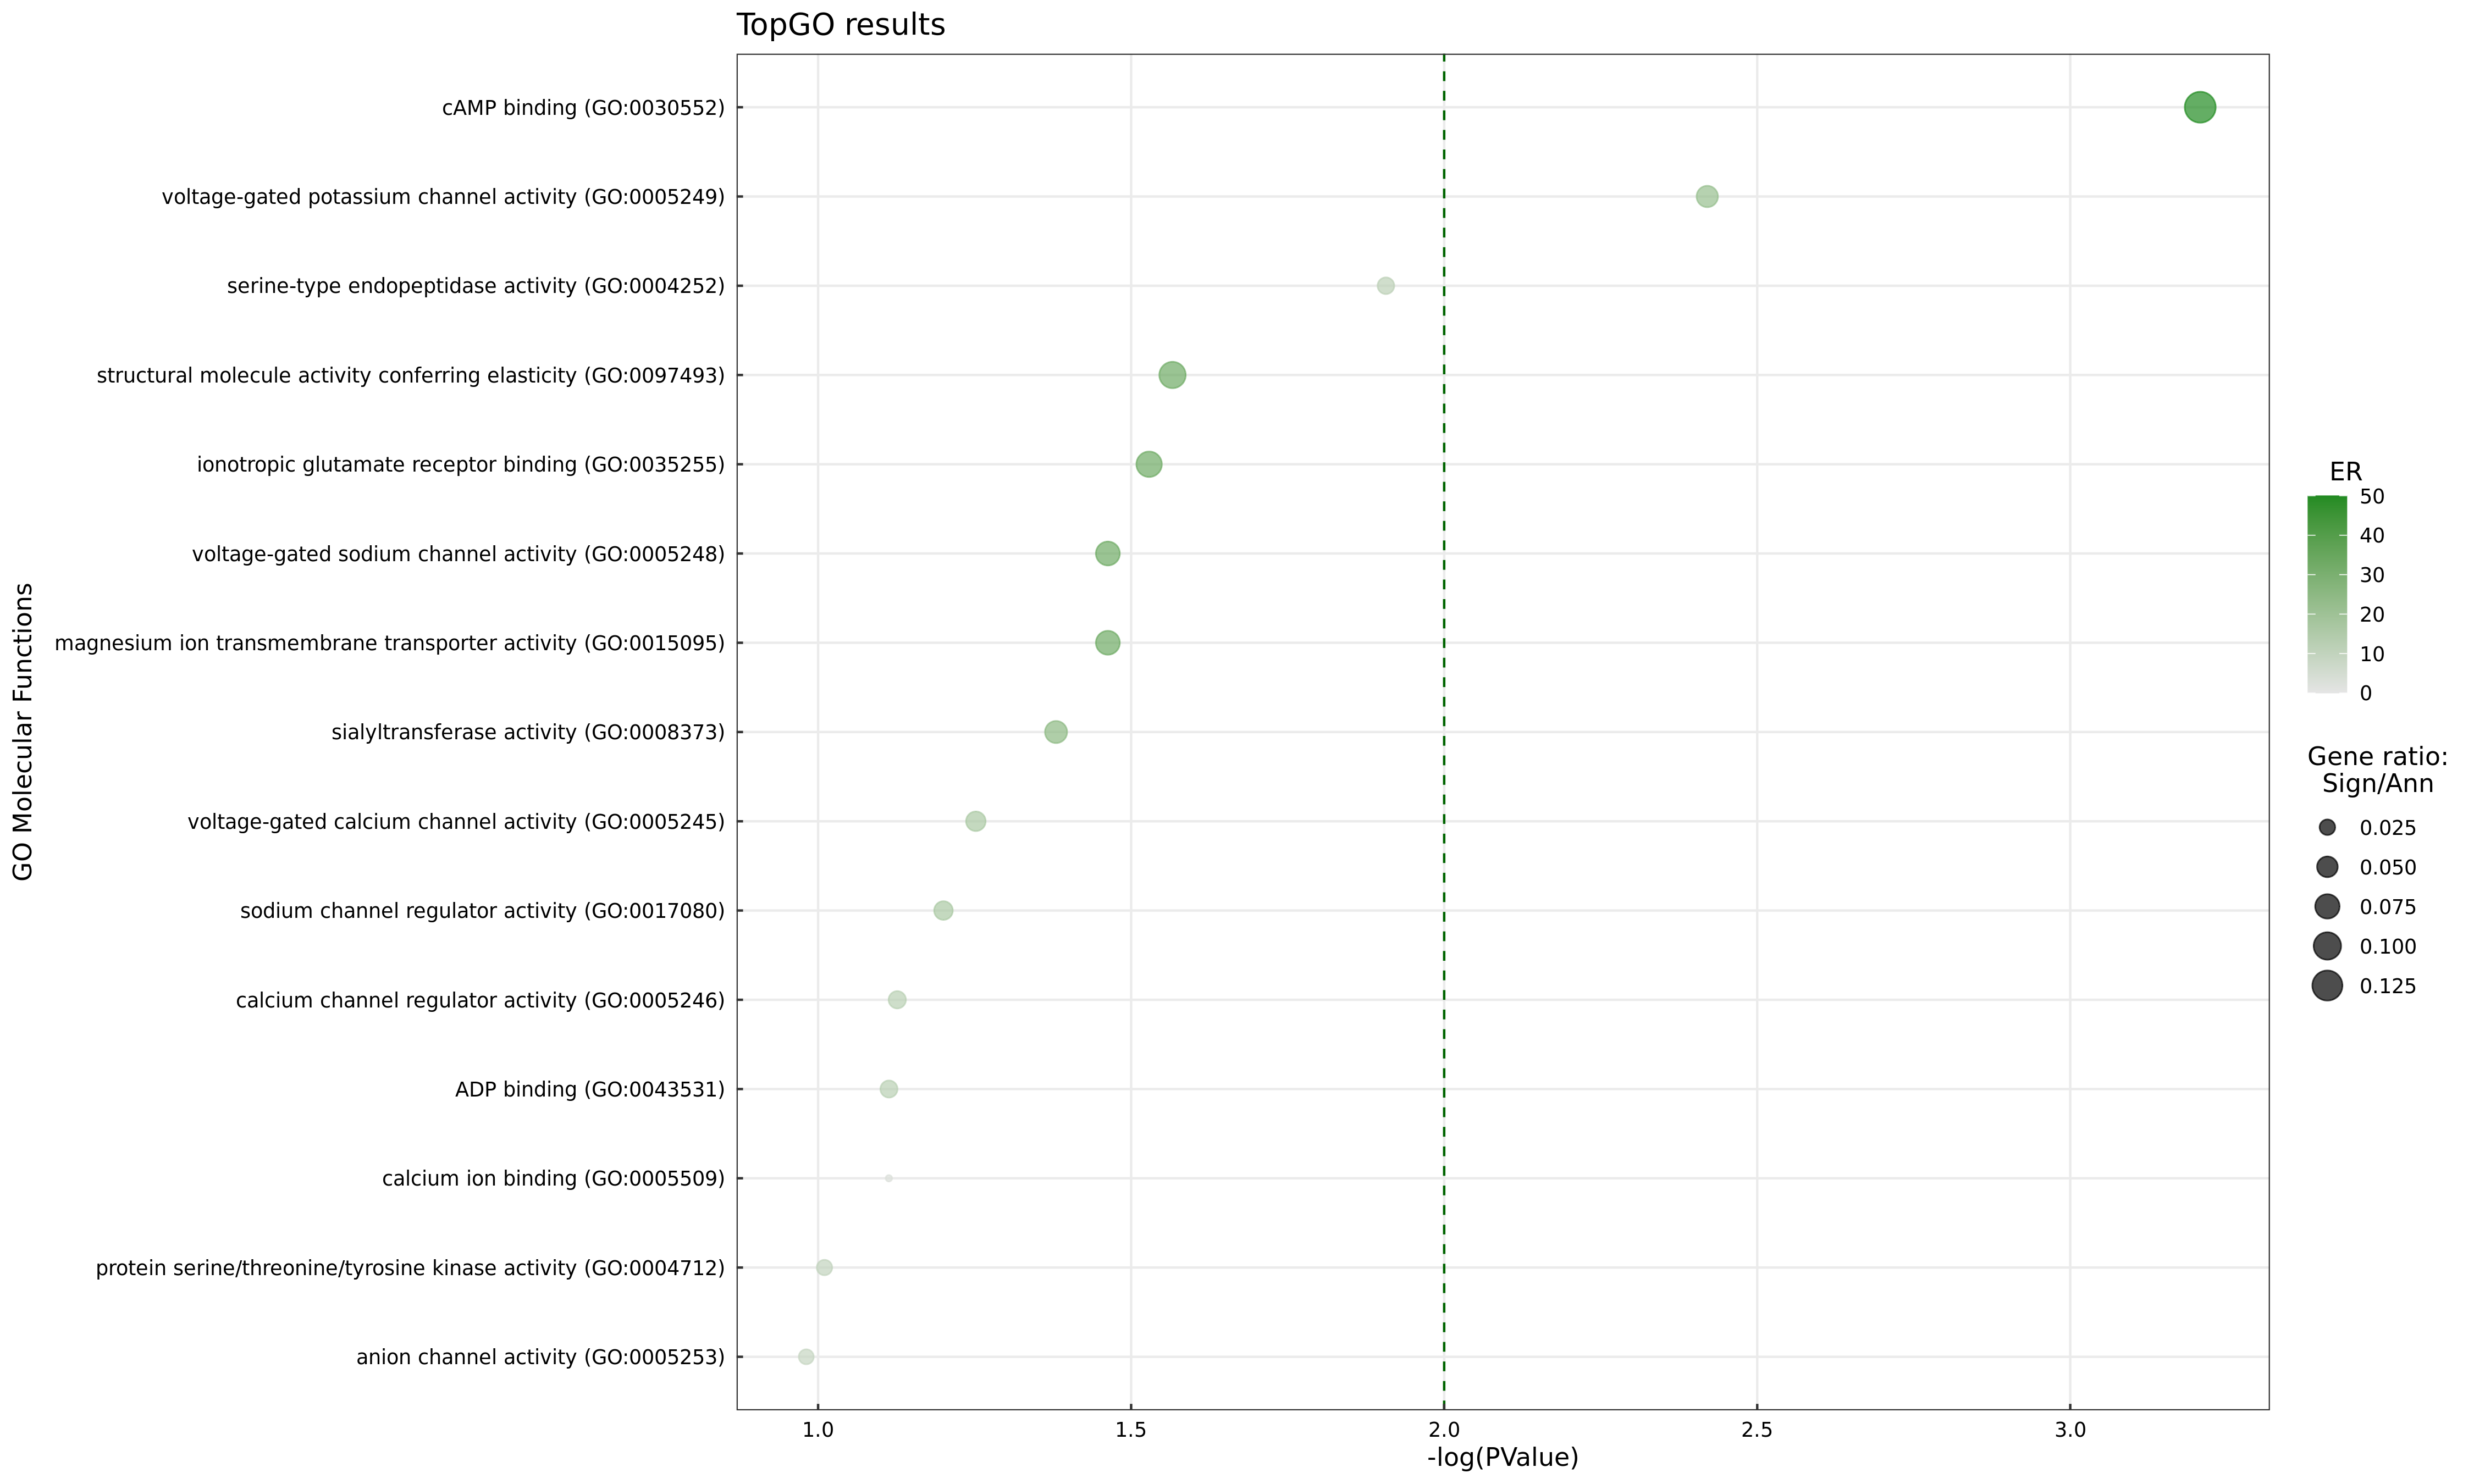

In [37]:
%%R
Res <- GenTable(GOdata, weight=results,
        orderBy="weight", topNodes=length(score(results)))
#print(Res[0:10,])
colnames(Res) <- c("GO.ID", "Term", "Annotated", "Significant", "Expected", "Statistics")
Res$ER <- Res$Significant / Res$Expected

image = bubbleplot(Res, Ont = 'MF', fillCol = 'forestgreen')

ggsave(file=paste0(folder, "TopGO_results_MF.pdf"), plot=image, width=12, height=4)

bubbleplot(Res, Ont = 'MF', fillCol = 'forestgreen')

In [38]:
#| echo: False

default_width = 20
default_height = 7
rpy2.ipython.rmagic.RMagics.setup_graphics = new_setup_graphics

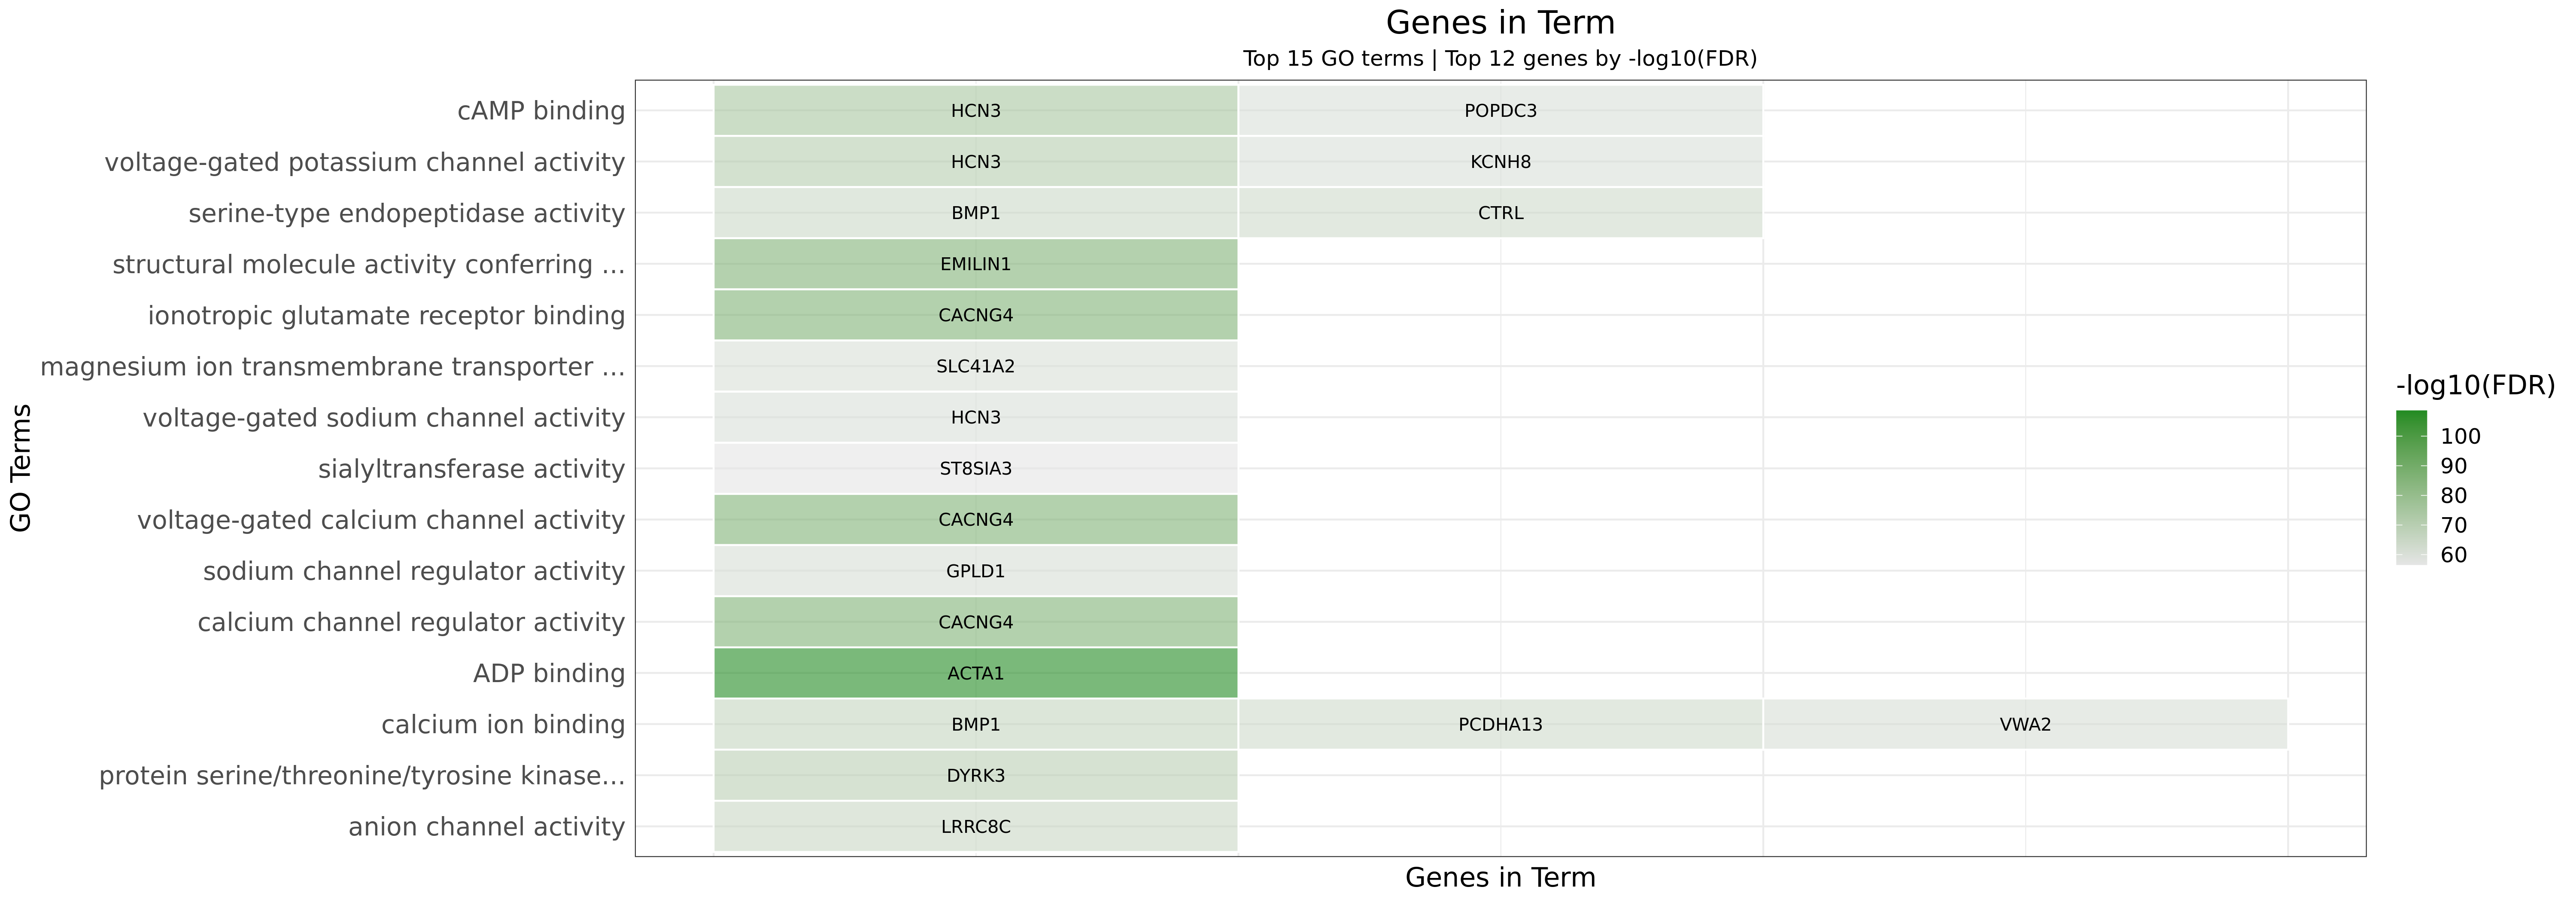

In [39]:
%%R -i markers
image = plotGenesInTerm_v1(Res, GOdata, SE = markers, nterms=15, ngenes=12,
                             fillCol='forestgreen', log = TRUE)

ggsave(file=paste0(folder, "Genes_in_Term_results_MF.pdf"), plot=image, width=12, height=4)

plotGenesInTerm_v1(Res, GOdata, SE = markers, nterms=15, ngenes=12,
                             fillCol='forestgreen', log = TRUE)

In [40]:
%%R -i markers -i folder
saveGenesInTerm(Res, GOdata, nterms = 20, path = paste0(folder,'GO_MF_genesInTerm_all.xlsx'), SE = markers)

In [41]:
#| echo: False

default_width = 15
default_height = 9
rpy2.ipython.rmagic.RMagics.setup_graphics = new_setup_graphics

### Cellular Compartment

In [42]:
%%R

GOdata <- new("topGOdata",
  ontology="CC",
  allGenes=allGenes_v,
  annot=annFUN.GO2genes,
  GO2genes=ann_org_CC,
  geneSel = selection,
  nodeSize=10)

In [43]:
%%R -o results

results <- runTest(GOdata, algorithm="weight01",statistic="fisher")

In [44]:
scores = ro.r.score(results)
score_names = ro.r(
'''
names(results@score)
'''
)
go_data = ro.r.GOdata

genesData = ro.r(
'''
geneData(results)
'''
)
genesData

array([11323,    29,    10,   170], dtype=int32)

In [45]:
#num_summarize = min(100, len(score_names))
results_table = ro.r.GenTable(go_data, weight=results,
        orderBy="weight", topNodes=len(scores))

In [46]:
results_table_py = ro.conversion.rpy2py(results_table)

In [47]:
scores_py = ro.conversion.rpy2py(scores)
score_names = [i for i in score_names]

In [48]:
scores_df = pd.DataFrame({'Scores': scores_py, 'GO.ID': score_names})
results_table_py = results_table_py.merge(scores_df, left_on = 'GO.ID', right_on = 'GO.ID')

In [49]:
results_table_py = results_table_py[results_table_py['Scores'] < 0.05]
results_table_py = results_table_py[results_table_py['Annotated'] < 200]
results_table_py = results_table_py[results_table_py['Annotated'] > 15]

intTable(results_table_py, folder = folder, fileName = 'GO_CC_all.xlsx', save = True)

Column
    [0] FileDownload(_transfers=1, auto=False, button_type='success', data='data:application/octet-st..., embed=True, file='./tables/cluster_13/GO_CC..., filename='GO_CC_all.xlsx', label='Download GO_CC_all.xlsx')
    [1] Tabulator(page_size=10, pagination='remote', value=        GO.ID  ...)

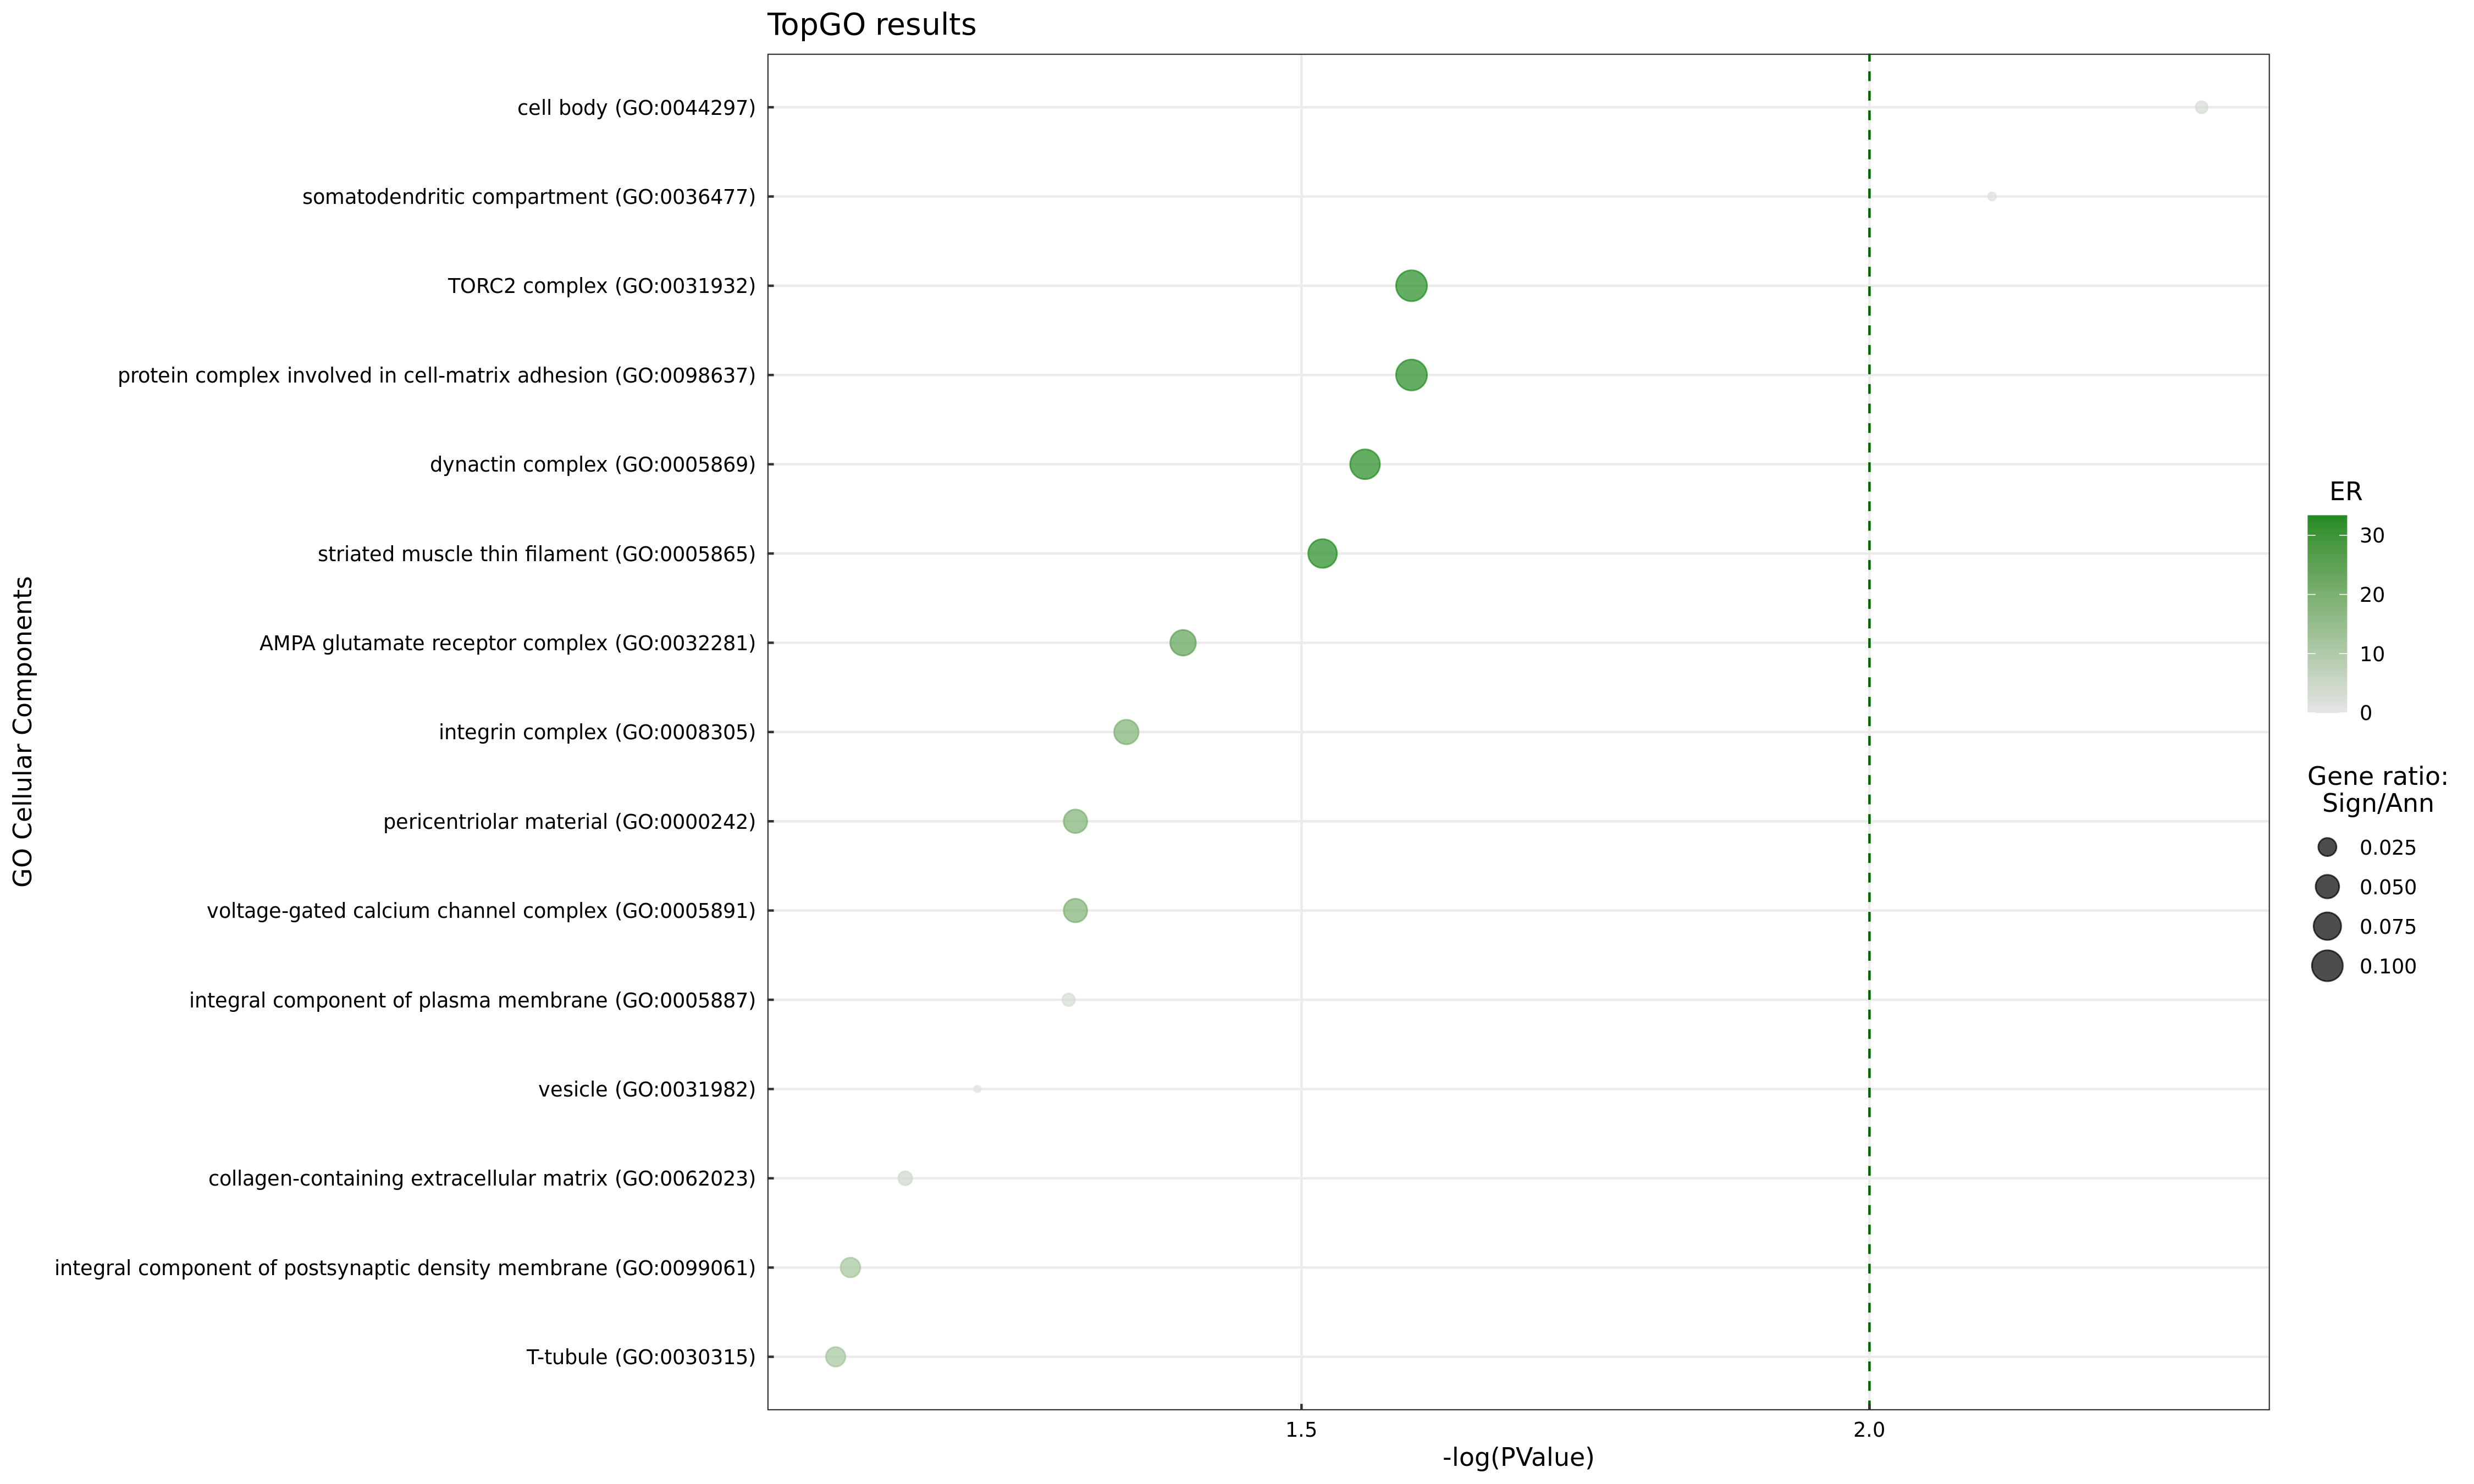

In [50]:
%%R
Res <- GenTable(GOdata, weight=results,
        orderBy="weight", topNodes=length(score(results)))
#print(Res[0:10,])
colnames(Res) <- c("GO.ID", "Term", "Annotated", "Significant", "Expected", "Statistics")
Res$ER <- Res$Significant / Res$Expected
image = bubbleplot(Res, Ont = 'CC', fillCol = 'forestgreen')

ggsave(file=paste0(folder, "TopGO_results_CC.pdf"), plot=image, width=12, height=4)

bubbleplot(Res, Ont = 'CC', fillCol = 'forestgreen')


In [51]:
#| echo: False

default_width = 20
default_height = 7
rpy2.ipython.rmagic.RMagics.setup_graphics = new_setup_graphics

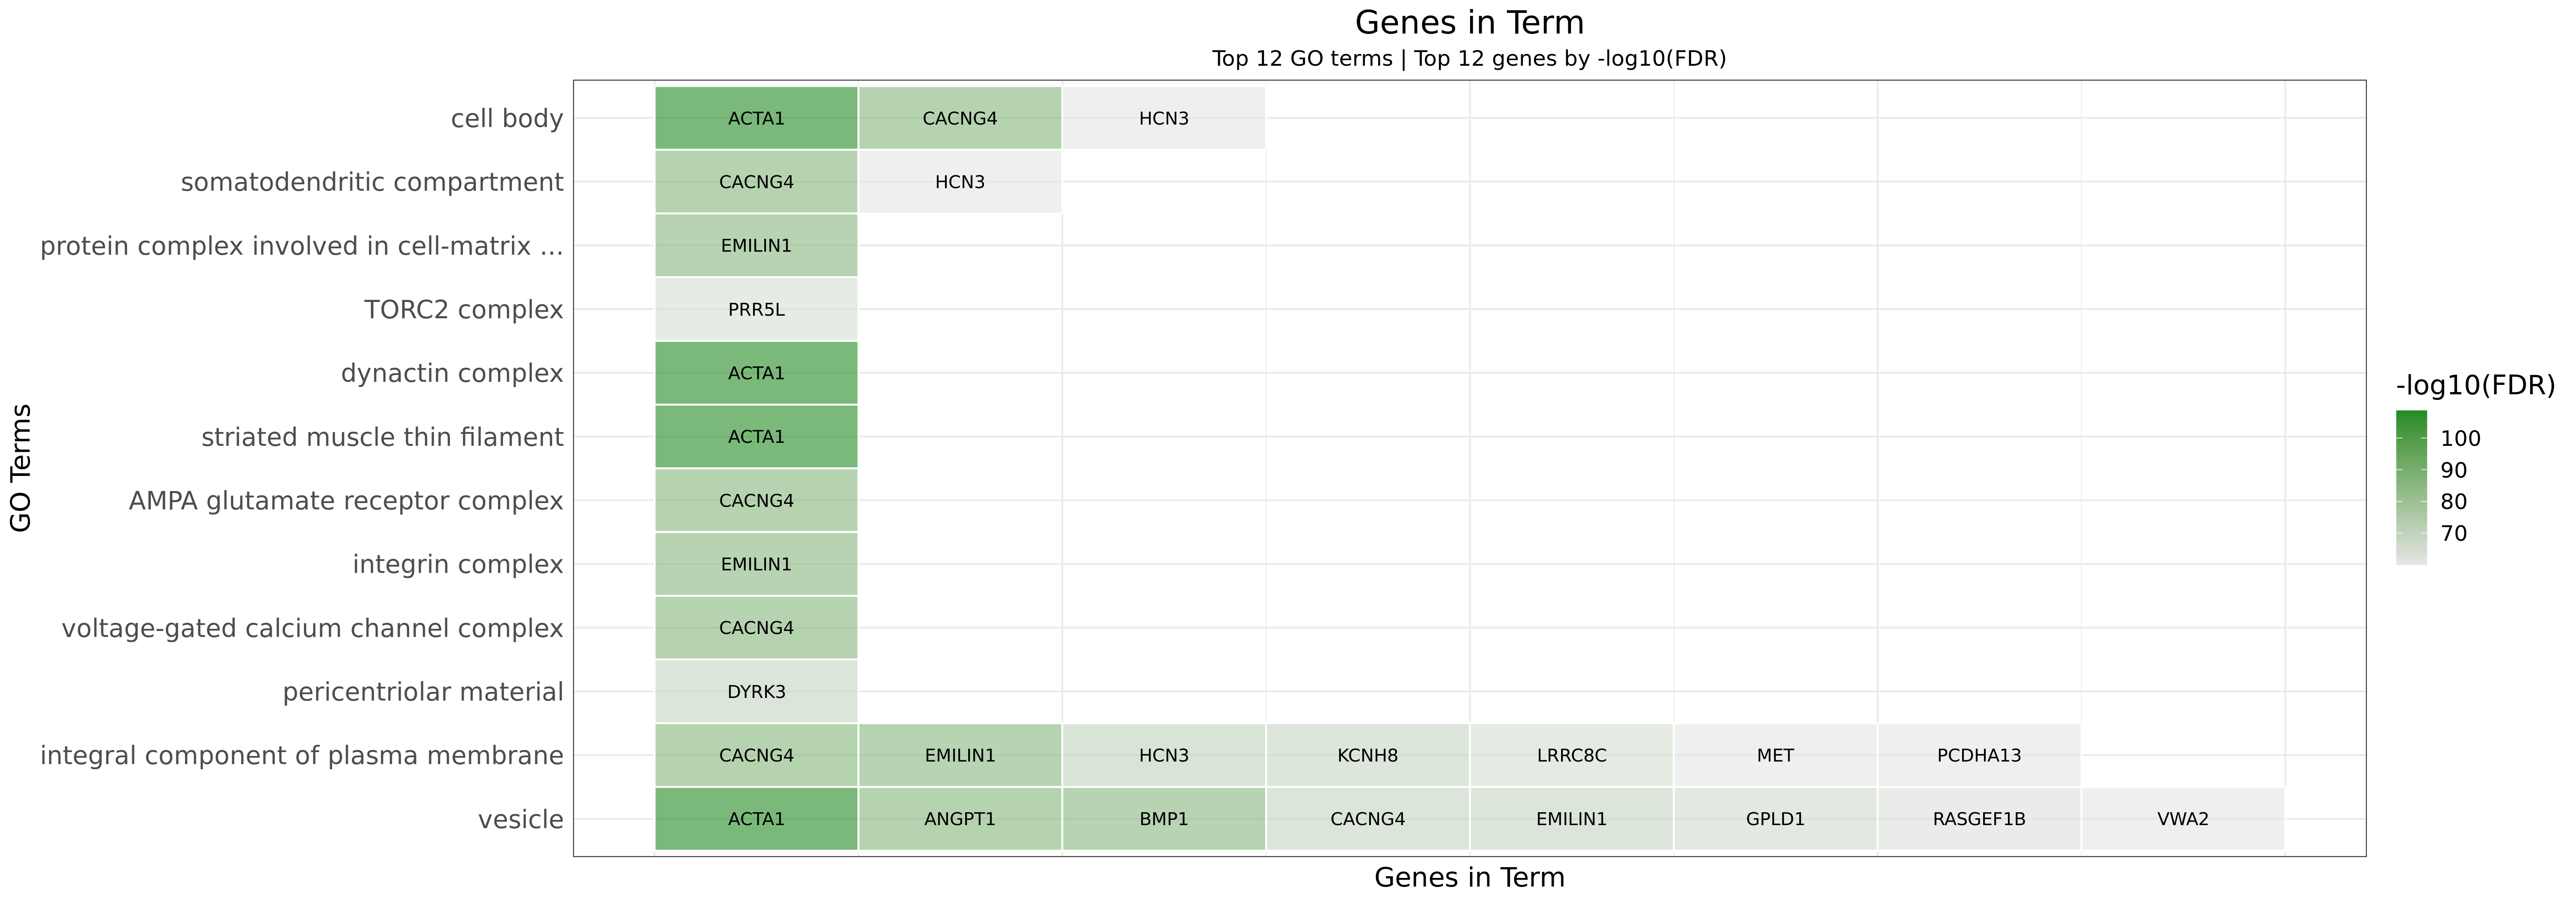

In [52]:
%%R -i markers
image = plotGenesInTerm_v1(Res, GOdata, SE = markers, nterms=12, ngenes=12,
                             fillCol='forestgreen', log = TRUE)

ggsave(file=paste0(folder, "Genes:_in_Term_results_CC.pdf"), plot=image, width=12, height=4)

plotGenesInTerm_v1(Res, GOdata, SE = markers, nterms=12, ngenes=12,
                             fillCol='forestgreen', log = TRUE)

In [53]:
%%R -i markers -i folder
saveGenesInTerm(Res, GOdata, nterms = 20, path = paste0(folder,'GO_CC_genesInTerm_all.xlsx'), SE = markers)

In [54]:
#| echo: False

default_width = 15
default_height = 9
rpy2.ipython.rmagic.RMagics.setup_graphics = new_setup_graphics

### Pathway annotation

In [55]:
#| echo: False
msigdb = dc.get_resource('MSigDB')

#### Reactome

In [56]:
curated = msigdb[msigdb['collection'].isin(['reactome_pathways'])]
curated = curated[~curated.duplicated(['geneset', 'genesymbol'])]

aggregated = curated[["geneset", "genesymbol"]].groupby("geneset").count().rename(columns={"genesymbol": "gene_count"})
curated = curated[~curated.geneset.isin(aggregated[aggregated.gene_count > 200].index.tolist())].copy()
curated = curated[~curated.geneset.isin(aggregated[aggregated.gene_count < 15].index.tolist())].copy()

In [57]:
rank = pd.DataFrame(markers['-log10(FDR)'])

rank_copy = rank.copy()
rank_copy['pval'] = markers.loc[rank.index].FDR

In [58]:
rank_copy

,-log10(FDR),pval
ACTA1,108.599792,2.513090e-109
SPIB,103.235154,5.818964e-104
SERTAD4,87.457454,3.487758e-88
CACNG4,86.153341,7.025198e-87
EMILIN1,85.562988,2.735346e-86
POPDC3,74.655607,2.210001e-75
MLKL,74.493027,3.213461e-75
AC007906.2,74.052394,8.863514e-75
FBXO48,72.240764,5.744282e-73
CCDC3,71.607396,2.469474e-72


In [59]:
results_table_py = run_ora_catchErrors(mat=rank.T, net=curated, source='geneset', target='genesymbol', verbose=False, n_up=len(rank), n_bottom=0)
len(results_table_py)

No significant term was found


0

In [60]:
intTable(results_table_py, folder = folder, fileName = 'Reactome_all.xlsx', save = True)

Column
    [0] FileDownload(_transfers=1, auto=False, button_type='success', data='data:application/octet-st..., embed=True, file='./tables/cluster_13/React..., filename='Reactome_all.xlsx', label='Download Reactome_all.xls...)
    [1] Tabulator(page_size=10, pagination='remote', value=Empty DataFrame
Columns: [...)

In [61]:
if len(results_table_py) > 0:
    results_table_py = getAnnGenes(results_table_py, GO2gene['reactome_pathways'], rank_copy)
    _, df = plotGenesInTerm(results = results_table_py, GO2gene = GO2gene['reactome_pathways'], DEGs = rank_copy, n_top_terms = 10, cmap = cmap_all)

In [62]:
if len(results_table_py) > 0:
    intTable(df, folder = folder, fileName = 'genesInTerm_Reactome_all.xlsx', save = True)

#### KEGG

In [63]:
curated = msigdb[msigdb['collection'].isin(['kegg_pathways'])]
curated = curated[~curated.duplicated(['geneset', 'genesymbol'])]

aggregated = curated[["geneset", "genesymbol"]].groupby("geneset").count().rename(columns={"genesymbol": "gene_count"})
curated = curated[~curated.geneset.isin(aggregated[aggregated.gene_count > 200].index.tolist())].copy()
curated = curated[~curated.geneset.isin(aggregated[aggregated.gene_count < 15].index.tolist())].copy()

In [64]:
results_table_py = run_ora_catchErrors(mat=rank.T, net=curated, source='geneset', target='genesymbol', verbose=False, n_up=len(rank), n_bottom=0)

No significant term was found


In [65]:
intTable(results_table_py, folder = folder, fileName = 'KEGG_all.xlsx', save = True)

Column
    [0] FileDownload(_transfers=1, auto=False, button_type='success', data='data:application/octet-st..., embed=True, file='./tables/cluster_13/KEGG_..., filename='KEGG_all.xlsx', label='Download KEGG_all.xlsx')
    [1] Tabulator(page_size=10, pagination='remote', value=Empty DataFrame
Columns: [...)

In [66]:
if len(results_table_py) > 0:
    results_table_py = getAnnGenes(results_table_py, GO2gene['kegg_pathways'], rank_copy)
    _, df = plotGenesInTerm(results_table_py, GO2gene['kegg_pathways'], rank_copy, n_top_terms = 10, n_top_genes = 15, cmap = cmap_all)

In [67]:
if len(results_table_py) > 0:
    intTable(df, folder = folder, fileName = 'genesInTerm_KEGG_all.xlsx', save = True)

:::